# Species Distribution Modelling with Python

## Introduction
Today, a wealth of biodiversity and earth observation data sets are freely available. Alongside advances in data processing technologies and cheap computing resources, data sources such as those used in this notebook -
the Global Biodiversity Information Facility (GBIF) [1], and WorldClim [24] - present extensive opportunities to build accurate, large-scale models with the potential to support decision-making in diverse fields.

This notebook considers one such application: Species Distribution Modelling. Species Distribution Models (SDMs) link environmental covariates, such as spatial distributions of climate or topographical variables, to spatially-explicit biodiversity data, such as species occurrence records [8, 13, 25].

SDMs have found applications in conservation, ecology, evolution and other fields [22], for purposes like guiding field research, informing conservation strategies and predicting ecological impacts of climate change [8, 23].

__What is covered in this notebook?__ <br>
Whilst SDM tools seem well-developed in the R programming language [26, 27, 28], I was only able to find one relevant (but limited) Python package, the companion publication of which notes the lack of Python SDM tools [13].

This notebook aims to present a basic SDM modelling workflow in Python, with example SDMs fitted to a sample of Panthera onca (Jaguar) occurrence observations downloaded from the GBIF, with WorldClim covariates. After presenting the methods used (data sourcing, preprocessing, and model selection and scoring), I go on to plot and discuss habitat suitability maps before concluding.


## Import data and packages

In [1]:
# Vector processing
import geopandas as gpd
import shapely

# Raster processing
import rasterio
import rasterio.plot
import rasterio.features
import rasterio.sample
from rasterio import windows

# Calcs and modelling
import numpy as np
import pandas as pd
from scipy.stats import zscore
import sklearn
from sklearn import model_selection
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import elapid as ela

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns
import geoplot as gplt

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
import glob
import warnings
from tqdm import tqdm
from ast import literal_eval

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)



## Methods

### Study area
The Jaguar's global range is mostly limited to the South American continent, though the distribution extends into Central America [29]. 

To speed up and simplify calculations and plotting, I select the contiguous part of the South American continent as the study area, shown in the figure below, using a standard ESRI continent shapefile [10]. Reducing the study area in this way is not typical of the SDM workflows referenced in this notebook, but makes sense for an introductory study, as the majority of the Jaguar range is covered, and we don't have to oversimplify the ecological processes governing movement and dispersal to/from islands.

Note that all plots are shown and calculations performed in projected coordinates. I'm using an equal-area projection with units of metres - see details in the reprojection section.


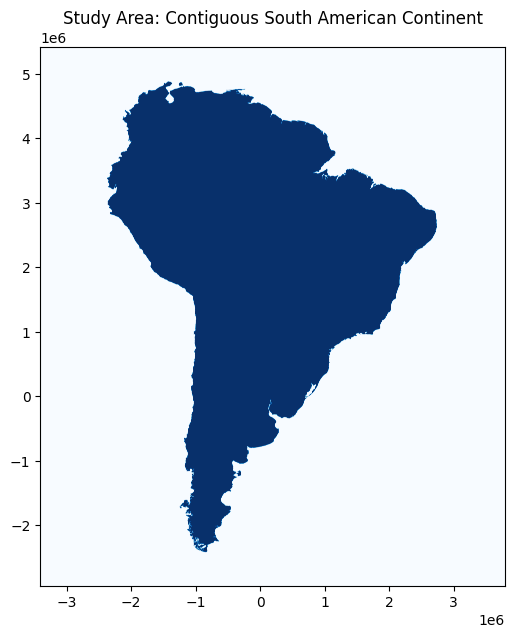

In [2]:
WORKING_CRS = 'ESRI:102033'
_sa = gpd.read_file('data/world_continents/')
_sa = _sa.to_crs(WORKING_CRS)
SA = _sa[_sa['CONTINENT'] == 'South America']['geometry'].iloc[0]

# Contigous SA continent as Shapely
SA = sorted(SA.geoms, key=lambda x: x.area)[-1] # just contiguous continent

# ...as a Geoseries
SA_geoseries = gpd.GeoSeries([SA], crs=_sa.crs)

# ...as np coords
SA_coords = np.array(SA.exterior.xy).T

# ...as a raster - and store some information describing the reference system and file structure
with rasterio.open('data/covar/esri_102033/wc2.1_30s_bio_11_South_America.tif') as file:
    SA_mask = rasterio.features.rasterize([SA], out_shape=file.shape, dtype=np.uint16, transform=file.transform)
    nodata_val, ref_shape, ref_bounds, ref_profile = file.nodata, file.shape, file.bounds, file.profile

# will write with a null nodata
ref_profile.update({'nodata': np.nan})

plt.figure(figsize=FIGSIZE)
plt.imshow(SA_mask, cmap='Blues', extent=[ref_bounds.left, 
                                          ref_bounds.right, 
                                          ref_bounds.bottom, 
                                          ref_bounds.top])
plt.title('Study Area: Contiguous South American Continent')
plt.show()

### Panthera onca occurrence data
Panthera onca (Jaguar) occurrence data was downloaded from the GBIF, for South America [1]. 

As WorldClim covariates are used in the next section, which represent global climate data for the period 1970 - 2000, the same period should be used for occurrence records.

Using a longer window (1960 - 2010) results in a four-fold increase in the number of records returned from GBIF. I retain the larger dataset under the assumption that averaged climate variables will have changed little on the longer window. For species distribution modelling aimed at studying changing habitat suitability with future climate scenarios, this kind of assumption would not apply.

Basis of record types were filtered to include human and machine observations, and records labelled as "occurrence", which removed 42 preserved specimen records from the dataset.

As an initial spatial cleaning step, exact geometry duplicates are dropped - this is a crude cleanup of erroneous geometries where the data provider used a centroid or building location (e.g. a lab location) instead of the actual occurrence location, and potentially a couple of good records that genuinely were detected at the same location (within precision). Spatial data quality is examined in more detail below.

There is a much more sophisticated way to do spatial cleaning on GBIF data with the R package CoordinateCleaner [31], with explicit functions to filter on country capitals, country centroids, known herbaria and zoo locations etc.



In [3]:
# Retain only columns of interest
occ_data = gpd.read_file('data/jaguar_occurence.csv')
occ_data = occ_data[['species', 'countryCode', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision','eventDate', 'basisOfRecord', 'issue']]

# Set geometry from lat/lon and delete redundant columns
occ_data = occ_data.set_geometry(gpd.points_from_xy(occ_data['decimalLongitude'], 
                                                    occ_data['decimalLatitude']),
                                 crs="EPSG:4326")
occ_data.drop(columns=['decimalLongitude', 'decimalLatitude'], inplace=True)

# Convert to datetime format and filter date range to match Worldclim date range extended by +-10 years
occ_data['eventDate'] = gpd.pd.to_datetime(occ_data['eventDate'])
occ_data = occ_data[(occ_data['eventDate'] < '01/01/2011') & (occ_data['eventDate'] >= '01/01/1960')]
print('Data date range: {0} to {1}'.format(occ_data['eventDate'].min(), occ_data['eventDate'].max()))

# Drop exact duplicates on geometry
occ_data = occ_data.drop_duplicates(subset=['geometry']) # Will do spatial thinning later anyway

Data date range: 1985-02-20 00:00:00 to 2010-12-16 18:19:00


Spatial accuracy and precision issues could be problematic for developing SDMs. The GBIF website lists several common error sources [32]:

1. Transformation errors
2. Value swapping (lat / lon)
3. Incorrect negation on lat / lon data
4. Zero-padding affecting apparent precision
5. Requirements to intentionally blur precision in the case of protection of sensitive species
6. Precision on gridded data (e.g. grid centroids listed, potentially without a coordinate uncertainty)

In addition, [33] notes that known default coordinate uncertainty values (301,3036,999,9999) should be cleaned, as they represent spurious location records (e.g. country centroids). However, none of the coordinate uncertainty values in records retrieved here match those values.

With reference to lat / lon data, transformation errors (1.), systematic coordinate swaps (2.) and missed or appended negative signs (3.) should be very obvious when plotting the occurrence records on a map, and are likely filtered by the clip to study area operation performed below.

Precision issues (4., 5., 6.) are harder to deal with - in fact most records don't provide coordinate precision and typically a lot of data is lost if this field is filtered out - so the suggestion is not to do so [33].


#### Reprojection
Here I use an equal-area projection (recommended for SDMs in [9]), ESRI:102033: Albers equal area conic.

Using equal-area projections in place of geodetic coordinates is recommended to avoid possible bias, though in practice this has little effect on SDM coefficients [9].

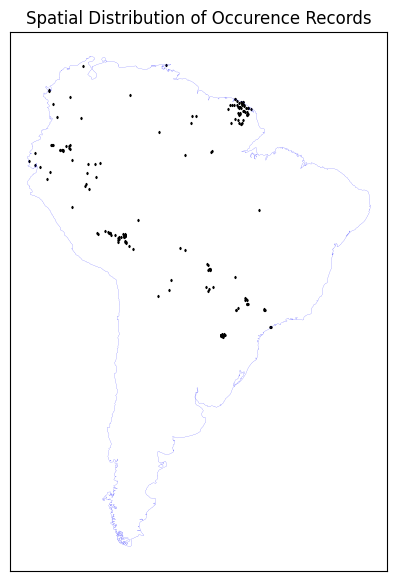

In [4]:
occ_data = occ_data.to_crs(WORKING_CRS)
occ_data = gpd.clip(occ_data, SA) # clip to SA polygon for consistency
occ_coords = np.vstack([occ_data['geometry'].x, occ_data['geometry'].y]).T

fig, ax = plt.subplots(figsize=FIGSIZE)
SA_geoseries.boundary.plot(ax=ax, color='blue', linewidth=0.1)
occ_data.plot(ax=ax, marker='d', markersize=1, color='k')
plt.title('Spatial Distribution of Occurence Records')
plt.xticks([])
plt.yticks([])
plt.show()

#### Spatial autocorrelation
Both covariate and response variables used to build SDMs on single-species occurrence datasets often display autocorrelation properties [6, 15-18]. 

Spatial autocorrelation due to exogenous (abiotic) factors exists [34] though can be entirely removed with a comprehensive set of environmental covariates [14]. However, endogenous (biotic) factors (which include dispersal, colonial breeding, home-range size, competition, predation etc.) are harder to deal with [14].

Spatial bias is often present in occurrence datasets (particularly those aggregated from multiple studies, or sourced from citizen science repositories) for instance due to accessibility of the sample area: species are sampled near roads, rivers and research stations [15-18, 34].

Combined, these effects lead to biased SDMs. One approach to tackling this problem is spatial rarefication / thinning of occurrence data: in [6] only one record per 5 square km is kept. Here points are filtered based on a circle of radius 2.5 km.

There are more sophisticated approaches to handling biases in this scenario, for example thinning occurrence and background points to be equidistant in geographical or environmental space [34], passing weight arrays into SDM fitting procedures, or by spatial block cross-validation [35].

In [5]:
# There's no built-in geodataframe thinning routine so do this manually

# Get spatial relations
indices = gpd.sjoin(occ_data, occ_data.set_geometry(occ_data.buffer(2.5e3)), 
                       how='left',
                       predicate='within')[['index_right']]

# Shuffle
indices = indices.sample(frac=1)

# For each spatially homogenous group (2.5km radius) compile lists of points to retain and thin
index_groups = indices.groupby(level=0, sort=False)
thin_list = set([])
keep_list = set([])
for left_index, group in index_groups:
    if not (left_index in thin_list):
        keep_list = keep_list | {left_index}
        thin_list = thin_list |  (set(group['index_right'].unique()) - {left_index})

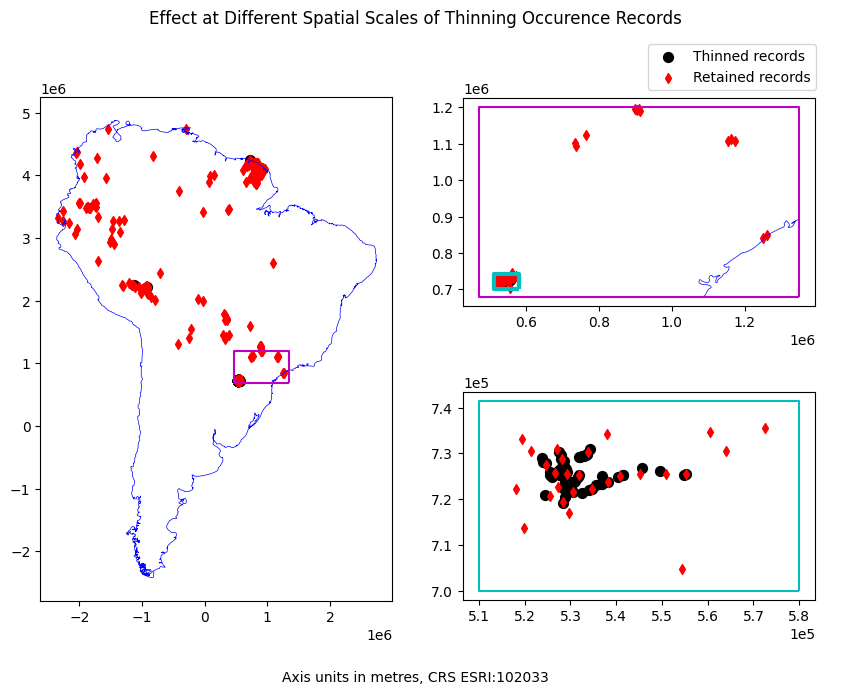

In [6]:
# Plot results of thinning at different scales
# Set up bboxes to zoom
ex1_bbox = (4.7e5, 6.8e5, 13.5e5, 12.0e5)
ar = (ex1_bbox[3] - ex1_bbox[1]) / (ex1_bbox[2] - ex1_bbox[0])
ex2_bbox = (5.1e5, 7e5, 5.8e5)
ex2_bbox = ex2_bbox + (ex2_bbox[1] + ar*(ex2_bbox[2] - ex2_bbox[0]),)

# Marker parameters
base_size = 50
thinned_size = 25

# Figure
fig = plt.figure(figsize=FIGSIZE)

# Continental scale
ax1= fig.add_subplot(1,2,1)
SA_geoseries.boundary.plot(ax=ax1, color='blue', linewidth=0.5)
occ_data.loc[list(thin_list)].plot(ax=ax1, markersize=base_size, color='k')
occ_data.loc[list(keep_list)].plot(ax=ax1, marker='d', markersize=thinned_size, color='r')
gpd.GeoSeries(shapely.geometry.box(*ex1_bbox)).exterior.plot(ax=ax1, color='m')

# Zoom 1
ax2 = fig.add_subplot(2,2,2)
SA_geoseries.boundary.clip_by_rect(*ex1_bbox).plot(ax=ax2, color='blue', linewidth=0.5)
occ_data.loc[list(thin_list)].clip_by_rect(*ex1_bbox).plot(ax=ax2, markersize=base_size, color='k')
occ_data.loc[list(keep_list)].clip_by_rect(*ex1_bbox).plot(ax=ax2, marker='d', markersize=thinned_size, color='r')
gpd.GeoSeries(shapely.geometry.box(*ex1_bbox)).exterior.plot(ax=ax2, color='m')
gpd.GeoSeries(shapely.geometry.box(*ex2_bbox)).exterior.plot(ax=ax2, color='c', linewidth=3)

# Zoom 2
ax3 = fig.add_subplot(2,2,4)
occ_data.loc[list(thin_list)].clip_by_rect(*ex2_bbox).plot(ax=ax3, markersize=base_size, color='k', label='Thinned records')
occ_data.loc[list(keep_list)].clip_by_rect(*ex2_bbox).plot(ax=ax3, marker='d', markersize=thinned_size, color='r', label='Retained records')
gpd.GeoSeries(shapely.geometry.box(*ex2_bbox)).exterior.plot(ax=ax3, color='c')

plt.figlegend(loc = (0.76, 0.87))
plt.suptitle('Effect at Different Spatial Scales of Thinning Occurence Records')
fig.text(0.5,0.025, 'Axis units in metres, CRS {}'.format(WORKING_CRS), ha='center', va='center')
plt.show()

The high-level spatial distribution of sampling positions remains largely unchanged, but filtering at smaller spatial scales has reduced the dataset by a third.

In [7]:
len(occ_data)

302

In [8]:
len(occ_data.loc[list(keep_list)])

196

In [9]:
occ_data = occ_data.loc[list(keep_list)]

### Climate and elevation data

Worldclim [24] climate variables were downloaded from worldclim.org, along with SRTM elevation data, all at 30s spatial resolution.

I start with the same set of variables as used by another Jaguar SDM study [8]: 

- precipitation of coldest quarter,
- precipitation of warmest quarter,
- precipitation seasonality (coefficient of variation),
- annual precipitation,
- mean temperature of wettest quarter,
- mean temperature of driest quarter,
- maximum temperature of warmest period,
- minimum temperature of coldest period,
- temperature season-ality (coefficient of variation), and
- annual mean temperature

Reprojections were handled outside of this notebook with GDAL.

In [10]:
# Bio var mappings
bio_vars = {
    'bio_19': 'precipitation of coldest quarter', 
    'bio_18': 'precipitation of warmest quarter',
    'bio_15': 'precipitation seasonality (coefficient   of   variation)',
    'bio_12': 'annual precipitation',
    'bio_8': 'mean temperature  of  wettest  quarter',
    'bio_9': 'mean temperature of driest quarter',
    'bio_5': 'maximum temperature of warmest period',
    'bio_6': 'minimum temperature of coldest period',
    'bio_4': 'temperature season-ality  (coefficient  of  variation)',
    'bio_1':  'annual mean temperature',
    'elev': 'SRTM elevation'
}

Sample the covariate values at the occurrence coordinates, and also at random coordinates:

In [11]:
bio_samples = {}
bio_samples_rand = {}

random_coords = SA_geoseries.sample_points(10000,
                                          method='uniform',
                                          seed=0).explode()
random_coords = np.vstack([random_coords.x, 
                           random_coords.y]).T

# For each biovar get its value at the occurrence record locations and background points locations
bio_var_paths = []
for bio_var in bio_vars:
    path = glob.glob('data/covar/esri_102033/*' + bio_var + '_South*.tif', recursive=False)[0]
    bio_var_paths.append(path)
    with rasterio.open(path) as rio_ds:
        bio_samples[bio_var] = np.array(list(rasterio.sample.sample_gen(rio_ds, 
                                                                          occ_coords, 
                                                                          indexes=1, 
                                                                          masked=False))).flatten() 

        bio_samples_rand[bio_var] = np.array(list(rasterio.sample.sample_gen(rio_ds, 
                                                                              random_coords, 
                                                                              indexes=1, 
                                                                              masked=False))).flatten() 

# Clean no_data values 
bio_sample_df = pd.DataFrame(bio_samples)
bio_sample_rand_df = pd.DataFrame(bio_samples_rand)

bio_sample_df = bio_sample_df[~(bio_sample_df == nodata_val).any(axis=1)]
bio_sample_rand_df = bio_sample_rand_df[~(bio_sample_rand_df == nodata_val).any(axis=1)]

This is equivalent to selecting from the underlying covariate distributions, at occurrence observation points.

#### Covariate histograms

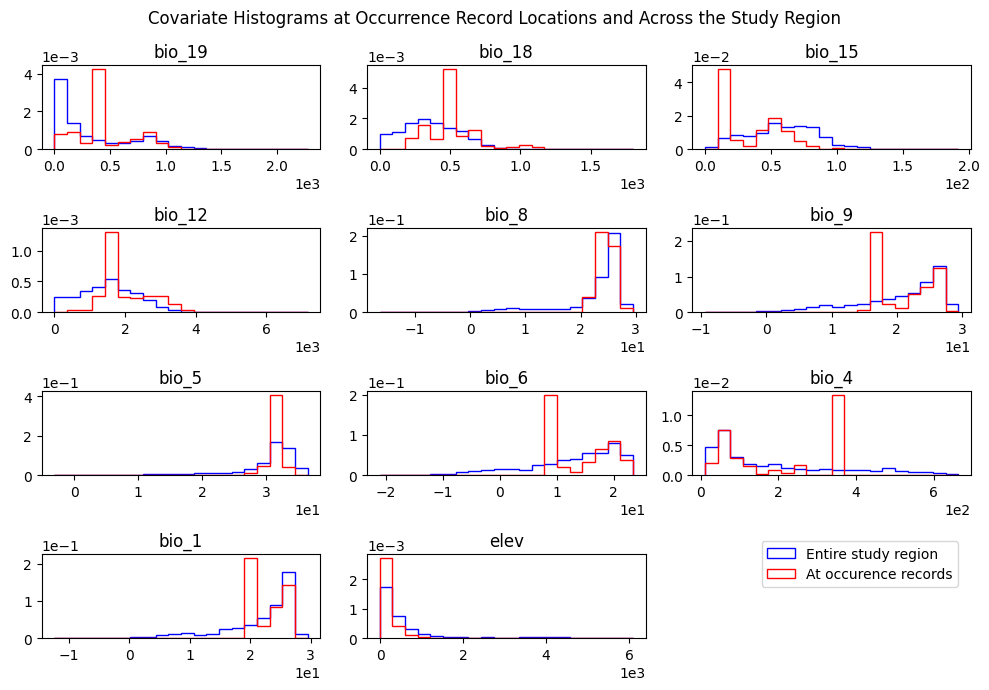

In [12]:
fig, axs = plt.subplots(figsize=FIGSIZE, nrows=4, ncols=3)
axs = axs.ravel()
for ax, bio_var in zip(axs, bio_vars):
    ax.hist([bio_sample_df[bio_var], 
             bio_sample_rand_df[bio_var]], 
            20, density=True, 
            color=['red', 'blue'],
            histtype='step', 
            stacked=False)#, cumulative=True)
    ax.set_title(bio_var)
fig.legend(labels=[ 'Entire study region', 'At occurence records',], prop={'size': 10}, bbox_to_anchor=(0.97, 0.23),)

axs[-1].set_axis_off()
fig.suptitle('Covariate Histograms at Occurrence Record Locations and Across the Study Region')
fig.tight_layout()

plt.show()

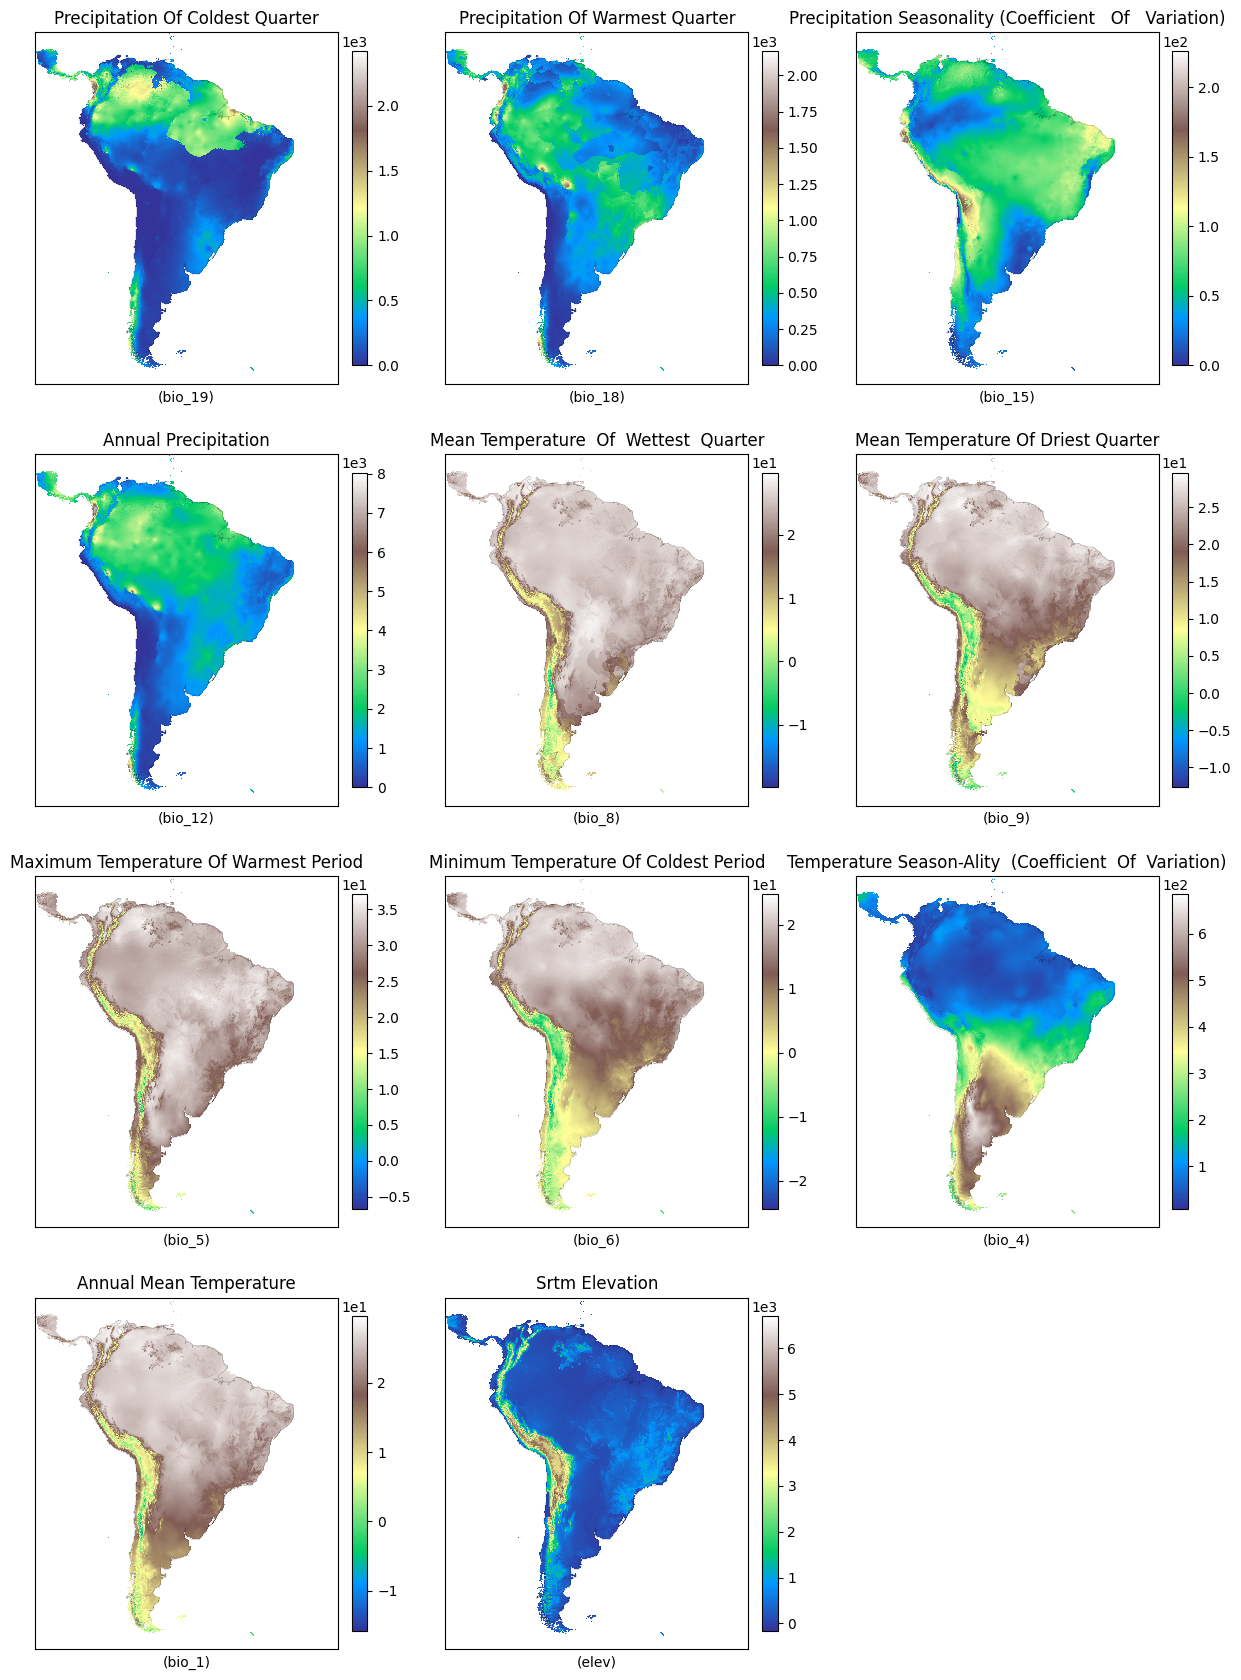

In [13]:
fig, axs = plt.subplots( nrows=4, ncols=3, figsize=(FIGSIZE[0]*3/2, FIGSIZE[1]*6/2))

for fp, name, ax in zip(bio_var_paths, bio_vars, axs.ravel()):
    with rasterio.open(fp) as file:
        output=file.read(1)
        mask=file.read_masks(1)

    im = ax.imshow(np.where(mask == 0, np.nan, output), 
                   cmap='terrain', 
                   extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                  )
    SA_geoseries.boundary.plot(ax=ax, color='black', linewidth=0.1)
    
    # occ_data.plot(ax=ax, markersize=5, color='k', marker='^', label='Occurrence records')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, -0.05, f'({name})', horizontalalignment='center', transform=ax.transAxes)
    fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    ax.set_title(bio_vars[name].title(), wrap=True)

axs[-1, -1].set_axis_off()
# fig.tight_layout()
plt.show()

## Feature selection
Now proceeding with climatic and topographic features as identified above, I'm running an additional feature selection routine as outlined in [6], which entails testing pairwise Spearman rank values, and for each pair where r > 0.8, discarding the feature with the lower PCA loading.

For SDM applications, it's also possible to assess histogram shape to aid in feature selection, with normally distributed or skewed bioclimatic distributions corresponding to relevant covariates, and no pattern or truncated histograms being irrelevant [11].

### Features with major disconituities
Due to calculation methodologies [25], some WorldClim variables show major discontinuities, which are visible in the continent-level plots above and will therefore be removed ([25] notes 84 publications taking such an approach)).

Note that bio_8 and bio_9 are highly correlated with elevation, the latter having a higher PCA loading, and therefore these variables would be dropped in the following feature selection process regardless.

In [14]:
to_drop = ['bio_8', 'bio_9', 'bio_18', 'bio_19']

bio_sample_df.drop(columns=to_drop, inplace=True)
bio_sample_rand_df.drop(columns=to_drop, inplace=True)
[bio_vars.pop(k) for k in to_drop]

['mean temperature  of  wettest  quarter',
 'mean temperature of driest quarter',
 'precipitation of warmest quarter',
 'precipitation of coldest quarter']

### PCA analysis

In [15]:
bio_sample_rand_df_norm = bio_sample_rand_df.apply(zscore)
base_pca = sklearn.decomposition.PCA(n_components=3)
base_pca.fit_transform(bio_sample_rand_df_norm)

print('Percentage of variance explained by PC1, PC2 and PC3 respectively:')
print(base_pca.explained_variance_ratio_)

Percentage of variance explained by PC1, PC2 and PC3 respectively:
[0.58807759 0.18920598 0.16364351]


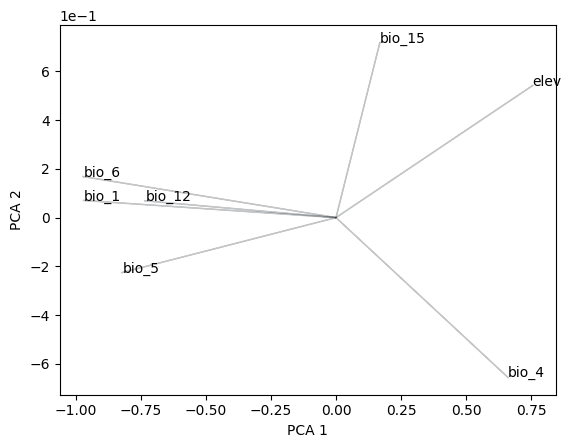

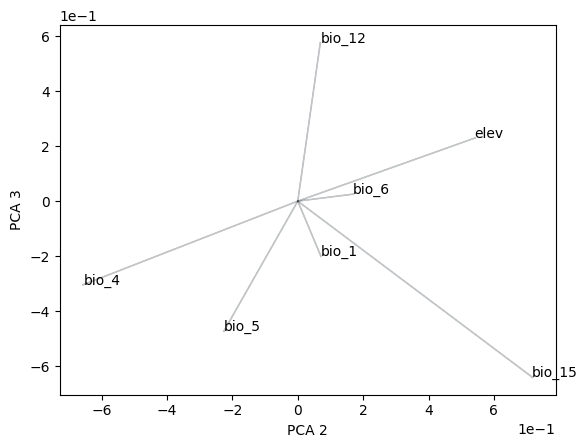

In [16]:

for pc_pair in [[1, 2], [2, 3]]: #, [1, 3]]:
    plt.figure()
    ax = plt.gca()
    for (x, y), label in zip(base_pca.components_.T[:, [pc_pair[0] - 1, pc_pair[1] -1]] * np.sqrt(base_pca.explained_variance_[[pc_pair[0] - 1, pc_pair[1] -1]]), 
                             bio_sample_rand_df_norm.columns):
        plt.arrow(0, 0, x, y, alpha=0.2)
        plt.text(x, y, label)
    
    plt.xlabel('PCA {}'.format(pc_pair[0]))
    plt.ylabel('PCA {}'.format(pc_pair[1]))
    plt.show()

### Collinearity analysis

In [17]:
corr_matrix = bio_sample_rand_df.corr(method='spearman')

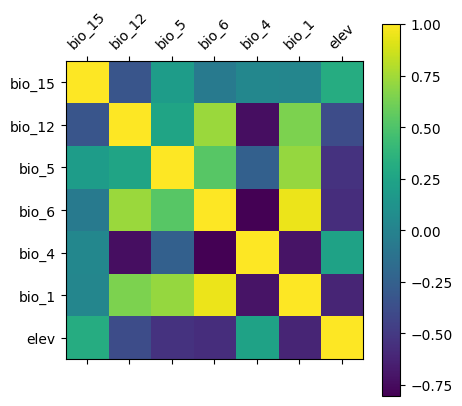

In [18]:
tick_pos = np.array(range(len(corr_matrix)))
plt.matshow(corr_matrix)
plt.xticks(tick_pos, corr_matrix.columns.values, rotation=45)
plt.yticks(tick_pos, corr_matrix.index.values)
plt.colorbar()
plt.show()

In [19]:
corr_pairs = (corr_matrix > 0.8).unstack()[np.triu(np.ones(corr_matrix.shape)).astype('bool').reshape(corr_matrix.size)]
corr_pairs = [pair for pair in corr_pairs[corr_pairs].index.values if pair[0] != pair[1]]
corr_pairs

[('bio_6', 'bio_1')]

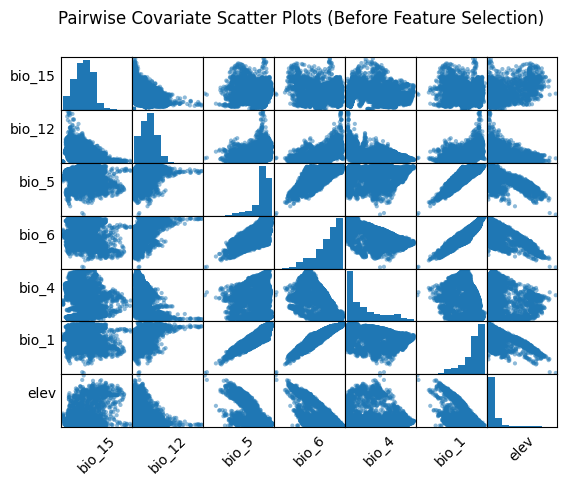

In [20]:
axs = pd.plotting.scatter_matrix(bio_sample_rand_df)
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Pairwise Covariate Scatter Plots (Before Feature Selection)')
plt.show()

In [21]:
covar_contributions = dict(zip(bio_sample_rand_df_norm.columns.to_list(), 
                               np.linalg.norm(base_pca.components_.T * np.sqrt(base_pca.explained_variance_), 
                                              axis=1)))
display(covar_contributions)
to_drop = list(set([sorted(pair, key=lambda x: covar_contributions[x])[0] for pair in corr_pairs]))

{'bio_15': 0.9753554385263389,
 'bio_12': 0.9325460652765645,
 'bio_5': 0.9729945188704011,
 'bio_6': 0.9846247561146286,
 'bio_4': 0.977601453939552,
 'bio_1': 0.9902779979490433,
 'elev': 0.9558396401262389}

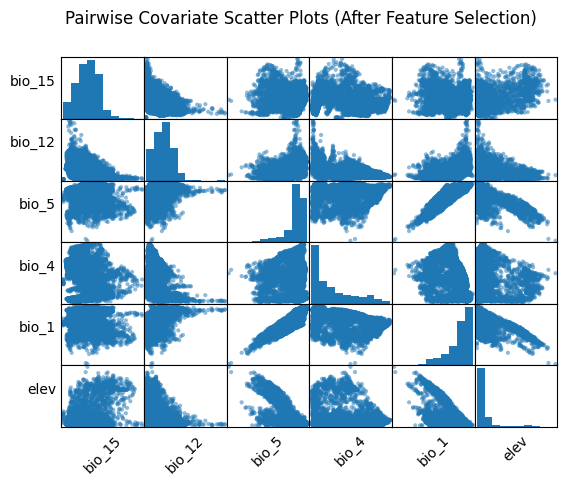

In [22]:
axs = pd.plotting.scatter_matrix(bio_sample_rand_df.drop(columns=to_drop))
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.suptitle('Pairwise Covariate Scatter Plots (After Feature Selection)')
plt.show()

Drop those columns in relevant data structures:


In [23]:
to_drop

['bio_6']

In [24]:
bio_sample_df.drop(columns=to_drop, inplace=True)
[bio_vars.pop(k) for k in to_drop]

['minimum temperature of coldest period']

## Results

### Environmental envelope

Here I run a simple envelope model similar to BIOCLIM [7], in which the minimal rectilinear envelope in covariate space is established with reference to covariate values at occurrence record locations. 

This method is sensitive to outliers, so we can look at a percentiles of the climatic profile corresponding to proportions of occurrence records included [36]. I calculate the "full" range envelope (corresponding to all occurrence locations) and also a "core" range envelope [11] corresponding to the 5th to 95th percentiles.

In [25]:
range_distribution = bio_sample_df.quantile(q=[0.0, 0.05, 0.95, 1.0])
range_distribution

,bio_15,bio_12,bio_5,bio_4,bio_1,elev
0.00,13.704205,504.0,11.400000,18.355698,7.362500,3.0
0.05,17.026096,1191.0,29.600000,42.711143,20.312500,59.0
0.95,71.629951,3286.0,32.900002,361.791382,26.316668,527.0
1.00,119.477875,6703.0,35.700001,364.601013,27.833334,3617.0


Each pixel on the entire study area can then be examined with reference to these bounds, for each covariate.

There is a choice regarding how to accept or reject each pixel - as some covariates may be in the range evelope, whilst others may not. Clearly a pixel for which all covariates fall inside or outside the range envelope would be accepted or rejected respectively.

For pixels with mixed results, we can take the intersection, average or union of covariate pass/fail values for each pixel to create the surface range maps [13] - here the intersection is taken, which is a strong constraint.

In [26]:
full_range = np.ones(ref_shape, dtype=bool)
core_range = np.ones(ref_shape, dtype=bool)

bio_var_paths = [] # REDEFINE to be just those of interest
for bio_var in range_distribution.columns:
    path = glob.glob('data/covar/esri_102033/*' + bio_var + '_South*.tif', recursive=False)[0]
    bio_var_paths.append(path)
    
    with rasterio.open(path) as file:
        values = file.read(1)

    full_range = np.logical_and(
                                  np.logical_and(full_range, (values >= range_distribution[bio_var].loc[0.0])), 
                                  (values <= range_distribution[bio_var].loc[1.0])
                                )
                                              
    core_range = np.logical_and(
                                  np.logical_and(core_range, (values >= range_distribution[bio_var].loc[0.05])), 
                                  (values <= range_distribution[bio_var].loc[0.95])
                                )


# Mask to study area
full_range = np.bitwise_and(full_range.astype(np.uint16), SA_mask)
core_range = np.bitwise_and(core_range.astype(np.uint16), SA_mask)

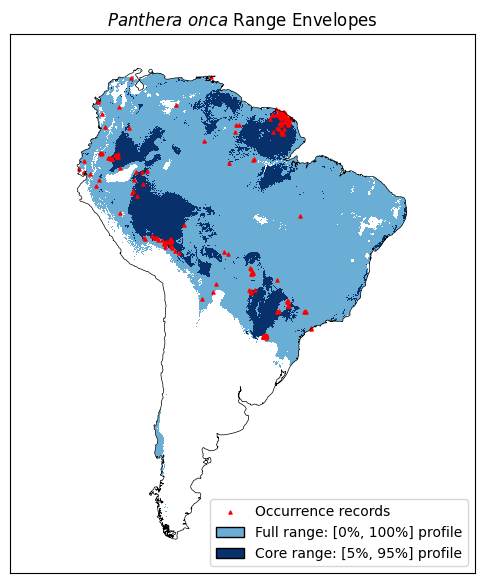

In [27]:
# Plot
cmap = mpl.colors.ListedColormap([mpl.cm.Blues.get_bad(), mpl.cm.Blues(0.5), mpl.cm.Blues(1.0)])
bounds = [0,1,2,3]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=FIGSIZE)

im = ax.imshow(full_range + core_range, 
          cmap=cmap,
          norm=norm,
          interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
          extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top])

SA_geoseries.boundary.plot(ax=ax, color='black', linewidth=0.5)
occ_data.plot(ax=ax, markersize=5, color='r', marker='^', label='Occurrence records')

plt.title('$\it{Panthera\ onca}$ Range Envelopes')

range_legend = [mpl.patches.Patch(facecolor=cmap.colors[1], edgecolor='k', label='Full range: [0%, 100%] profile'),
                mpl.patches.Patch(facecolor=cmap.colors[-1], edgecolor='k', label='Core range: [5%, 95%] profile')]



plt.xticks([])
plt.yticks([])
plt.legend(handles=ax.get_legend_handles_labels()[0] + range_legend, bbox_to_anchor=[1.0,0.15])

plt.show()

Note that the full range includes the core range (is the union of blue regions in figure).

Repeat analysis using "out-the-box" equivalent [13] and check consistency:

In [28]:
envelope_ela  = ela.NicheEnvelopeModel(percentile_range=[0, 100], overlay='intersection')
envelope_ela.fit(bio_sample_df, np.ones(len(bio_sample_df)))

_temp_path = 'data/models/ela_niche_envelope.tif'
ela.apply_model_to_rasters(envelope_ela, bio_var_paths, _temp_path, quiet=True)

# and read into memory
with rasterio.open(_temp_path, 'r') as src:
    ela_niche = src.read(1, masked=True)

My manual range envelope and the ELAPID "out-the-box" version are identical:

In [29]:
(np.abs(np.bitwise_and(ela_niche.astype(np.uint16), SA_mask) - full_range)).max()

0

In [30]:
with rasterio.open('data/models/manual_niche_envelope.tif', 'w', **ref_profile) as file:
    file.write(full_range.astype(ref_profile['dtype']), 1)
full_range = full_range.astype(bool)

# Delete memory-heavy vars not used in further computation
del values, core_range

###  OneClassSVM & presence-background models
In this section several SDMs are compiled based on the occurrence datasets, randomly generated background coordinates, and the selected abiotic covariates.

The study area is reduced to the full extent of the surface range envelope computed in the previous section, which can reduce overfitting [13]. 




In [31]:
##### First generate background points #####
# Get surface range envelope (new study area)
with rasterio.open('data/models/manual_niche_envelope.tif') as rio_ds:
    _full_range = rio_ds.read(1)
    envelope_geometry = list(rasterio.features.shapes(_full_range, transform=rio_ds.transform))
    full_range = _full_range.astype(bool)
    del _full_range
    
envelope_geoseries = gpd.GeoSeries(shapely.geometry.MultiPolygon(
                                        [(entity[0]['coordinates'][0],
                                        entity[0]['coordinates'][1:]) for entity in envelope_geometry[:-1]]
                                    ), crs = ref_profile['crs'])

Background points are generated as a random sample on that area. Seed 10,000 points [4, 5, 16], and sample covariates at those points.

In [32]:
background_coords = envelope_geoseries.sample_points(10000, method='uniform', seed=0).explode()
background_coords = np.vstack([background_coords.x, background_coords.y]).T

bio_sample_background = {}
for bio_var, path in zip(bio_vars.keys(), bio_var_paths):
    with rasterio.open(path) as rio_ds:
        bio_sample_background[bio_var] = np.array(list(rasterio.sample.sample_gen(rio_ds, 
                                                                  background_coords, 
                                                                  indexes=1, 
                                                                  masked=False))).flatten() 
bio_sample_background_df = pd.DataFrame(bio_sample_background)

Now set up features and targets, scikit-learn-style. Normalize covariates for model development.

In [33]:
##### Set up test, train features and targets #####
X = pd.concat([bio_sample_df, bio_sample_background_df], ignore_index=True)
y = pd.DataFrame([1]*len(bio_sample_df) + [0]*len(bio_sample_background_df), columns=['target'])

# Normalization
X_mean = X.mean()
X_std = X.std()

def norm_covs(cov, i):
    return (cov - X_mean[i]) / X_std[i]
    
X_norm = (X - X_mean) / X_std 

Now define the models: I am using four classes of model, two with multiple parameter sets. 

OneClassSVM is an unsupervised outlier detection model, applied in a scikit-learn tutorial [3] as a density estimator trained on presence-only data.

In [34]:
svm_1cl = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)

MaxEnt is also a density estimator, though it uses presence/background data. It is used widely in the SDM literature [20, 36]; here a standard implementation is used [13], with a variety of values for the regularization parameter (beta): [16] suggests that beta should be empirically found. I use a similar set of beta values to those used in [20].

In [35]:
max_ent_model = [ela.MaxentModel(transform='cloglog', beta_multiplier=beta) for beta in [0.01, 0.1, 0.5, 1, 2, 3, 5]]

LogisticRegression is a type of Generalized Linear Model (GLM) with a logit link function. GLMs (and also Generalized Additive Models (GAMs)) are very popular SDM approaches [36].

In general, GLMs/GAMs can be used with background data instead of absence/pseudo-absence but requires case-control design [36, 37]. This is difficult in practice - especially in Python with scikit-learn, because it requires modification of the underlying logistic function to include a correction term based on the proportions of occupied and unoccupied locations in the study area, which is rarely known [37]. Therefore this model (and in fact the others) are making relative predictions about species presence, instead of outputting a direct probability of species presence.


In [36]:
lr_classifier = sklearn.linear_model.LogisticRegression()

RandomForest is a tree-based model, another popular class of SDM approaches. Here it's implemented as in [2, 19]. Note that RFs are sensitive to class imbalance & overlap, both of which are present here by default due to the requirement that background points fully sample the study area. There are several ways to deal with this issue [19], though these methods are beyond the scope of this notebook - here I just use a standard parameter of the scikit-learn RandomForest class to weight the samples based on class prevalence in the dataset.

In [37]:
rf_classifier = [sklearn.ensemble.RandomForestClassifier(n_estimators=500, criterion='gini'), # Using gini (this is the default), and 500 trees as suggested in [19]
                sklearn.ensemble.RandomForestClassifier(n_estimators=500, criterion='gini', class_weight='balanced')]


The MaxEnt model doesn't behave with scikit-learn scoring, so I'm implementing a cross validation routine manually here.

The area under the curve (AUC) of the receiver operating characteristic (ROC) is a measure of the performance of binary classifiers and takes values in the range [0.5, 1] (in practice - theoretically between [0, 1]). The measure is commonly used to assess performance of SDMs, often alongside a threshold-dependent scorer (e.g. True Skill Statistic, TSS) [19, 38].


In [44]:
models = [*max_ent_model, svm_1cl, *rf_classifier, lr_classifier]

# Assess model performance
def cross_validate(X, y, models=None, scorers=None, nfolds=5):
    scores = {model.__str__() : {scorer.__name__: 0} for model in models for scorer in scorers}
    for run in range(nfolds):    
        # TO DO: This is sampling with replacement, which technically is not cross validation - refactor to shuffle outside the loop and split the data into discrete sets
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 1.0 / nfolds)
        for model in models:        
            if hasattr(model, 'predict_proba'):
                model.fit(X_train, y_train)
                assert model.classes_[1] == 1 # needs to be ordered to ensure the set of probabilities corresponding to the positive target is taken
                y_pred = model.predict_proba(X_test)[:,1]
            
            elif hasattr(model, 'decision_function'): # this is a 1-class SVM style model
                indexer = (y_train==1).values # Single class estimation, do not include background points
                model.fit(X_train[indexer], y_train[indexer])
                y_pred = model.decision_function(X_test)
            
            for scorer in scorers:
                scores[model.__str__()][scorer.__name__] += (1.0 / nfolds) * scorer(y_test, y_pred)
    
    return scores
        

test_scores = cross_validate(X_norm, 
                             y,
                             models=models, 
                             scorers=[sklearn.metrics.roc_auc_score])

print('AUC scores for all models are as follows:')
display(test_scores)

AUC scores for all models are as follows:


{'MaxentModel(beta_multiplier=0.01)': {'roc_auc_score': 0.8757467533191965},
 'MaxentModel(beta_multiplier=0.1)': {'roc_auc_score': 0.8730030744929804},
 'MaxentModel(beta_multiplier=0.5)': {'roc_auc_score': 0.8648404981587722},
 'MaxentModel(beta_multiplier=1)': {'roc_auc_score': 0.86239191457227},
 'MaxentModel(beta_multiplier=2)': {'roc_auc_score': 0.8610458803725292},
 'MaxentModel(beta_multiplier=3)': {'roc_auc_score': 0.8612553035956488},
 'MaxentModel(beta_multiplier=5)': {'roc_auc_score': 0.8611460983920829},
 'OneClassSVM(gamma=0.5, nu=0.1)': {'roc_auc_score': 0.730973073406812},
 'RandomForestClassifier(n_estimators=500)': {'roc_auc_score': 0.9444493912301641},
 "RandomForestClassifier(class_weight='balanced', n_estimators=500)": {'roc_auc_score': 0.9447056334520789},
 'LogisticRegression()': {'roc_auc_score': 0.8409620534668538}}

Filter for the best performing model in each model family - but keep the best and worst MaxEnt models for comparison.

In [39]:
base_models = list(set([model_full_name.split('(')[0] for model_full_name in test_scores.keys()]))
best_models = []
best_scores = []
for base_model in base_models:
    results_set = [(model,score) for (model_name, score), model in zip(test_scores.items(), models)  if model_name.startswith(base_model)]
    best_result = sorted(results_set, key=lambda x:x[1]['roc_auc_score'])[-1]
    best_models.append(best_result[0])
    best_scores.append(best_result[1])

    if 'Maxent' in base_model: # Also store worst model for comparison
        worst_result = sorted(results_set, key=lambda x:x[1]['roc_auc_score'])[0]
        best_models.append(worst_result[0])
        best_scores.append(worst_result[1])

Now train on full dataset, and run predictions on the full study area. This is computationally intensive so I'm using windowed reading and writing functionality from rasterio.

In [ ]:
for model in best_models:
    model.fit(X_norm, y)

# Apply to full continent using windowed read
with rasterio.open(bio_var_paths[0]) as src:
    feature_windows = [_wind for _, _wind in src.block_windows(1)]

n = 50
feature_windows = [windows.union(*feature_windows[i:i + n]) for i in range(0, len(feature_windows), n)]
write_paths = ['data/models/{}.tif'.format(model.__str__()) for model in best_models]
write_datasets = [rasterio.open(path, 'w+', **ref_profile) for path in write_paths]

# Start off by tagging the new datasets with the model score
for ds, score in zip(write_datasets, best_scores):
    ds.update_tags(score=score)
    
for feature_window in tqdm(feature_windows):
    row_slice, col_slice = feature_window.toslices()
    _reads = []
    _masks = [full_range[row_slice, col_slice]] # only compute where necessary
    
    # Get the covariates in this window
    for i, bio_var_path in enumerate(bio_var_paths):
        with rasterio.open(bio_var_path) as src:
            _reads.append(norm_covs(src.read(1, window=feature_window), i)) # Models are trained on normalised inputs, so predictions must be generated on the same
            _masks.append(src.read_masks(1, window=feature_window))    
    _reads = np.stack(_reads, axis=2)      
    _masks = np.logical_and.reduce(_masks)

    # Run each model prediction and write to file
    for model, dst in zip(best_models, write_datasets):
        _output = np.empty(_masks.shape)
        _output[:] = np.nan
        if not (~_masks).all():
            if hasattr(model, 'predict_proba'):
                assert model.classes_[1] == 1 # needs to be ordered to ensure the set of probabilities corresponding to the positive target is taken
                _output[_masks] = model.predict_proba(_reads[_masks])[:, 1]
            
            elif hasattr(model, 'decision_function'):
                _output[_masks] = model.decision_function(_reads[_masks])

        # Save results
        dst.write(_output, window=feature_window, indexes=1)

    
[ds.close() for ds in write_datasets]

And now let's look at the suitabiltiy distributions for the best models, starting with envelope and density estimation models:

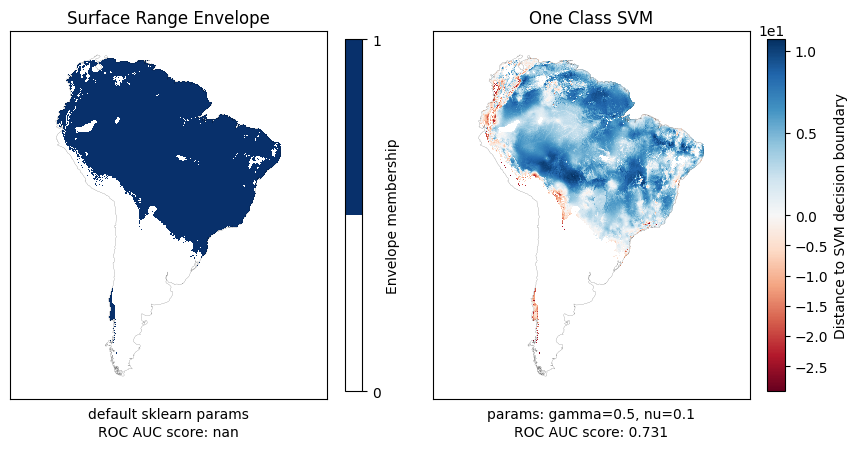

In [42]:
# Read in vars from here so that the model does not have to be re-run every time
_res_paths = glob.glob('data/models/*.tif')
env_paths = [i for i in _res_paths if (i not in suit_paths) and ('ela' not in i)] # And ignore the elapid model, as it is the same as the manual envelope
env_models = [i.split('/')[-1].rstrip('.tif') for i in env_paths]

fig, ax = plt.subplots(len(env_models) // 2, 2, figsize=(FIGSIZE[0], FIGSIZE[1]*len(env_models) // 2))

labels = ['Envelope membership', 'Distance to SVM decision boundary']
cmaps = [mpl.colors.ListedColormap(['white', mpl.cm.Blues.get_over()]), 'RdBu']
norms = [None, mpl.colors.TwoSlopeNorm(0)]
ticks = [[0, 1], None]
titles = ['Surface Range Envelope', 'One Class SVM']
for i, (fp, name, ax) in enumerate(zip(env_paths, env_models, ax.ravel())):
    with rasterio.open(fp) as file:
        output=file.read(1)
        try:
            score = literal_eval(file.tags()['score'])['roc_auc_score']
        except KeyError:
            score = np.nan
    
    im = ax.imshow(output, 
                   cmap=cmaps[i], 
                   extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                   norm=norms[i])
    SA_geoseries.boundary.plot(ax=ax, color='black', linewidth=0.1)

    ax.set_xticks([])
    ax.set_yticks([])
    model_base_name = name.split('(')[0]
    params_name = None if '(' not in name else name.split('(')[1].rstrip(')')
    ax.set_title(titles[i])
    ax.text(0.5, -0.05, (('params: ' + params_name) if params_name else 'default sklearn params'), horizontalalignment='center', transform=ax.transAxes)
    ax.text(0.5, -0.10, 'ROC AUC score: ' + f'{score:.3f}', horizontalalignment='center', transform=ax.transAxes)
    fig.colorbar(im, label=labels[i], fraction=0.05, ticks=ticks[i])

plt.show()

And also the models which produce probability-style outputs:

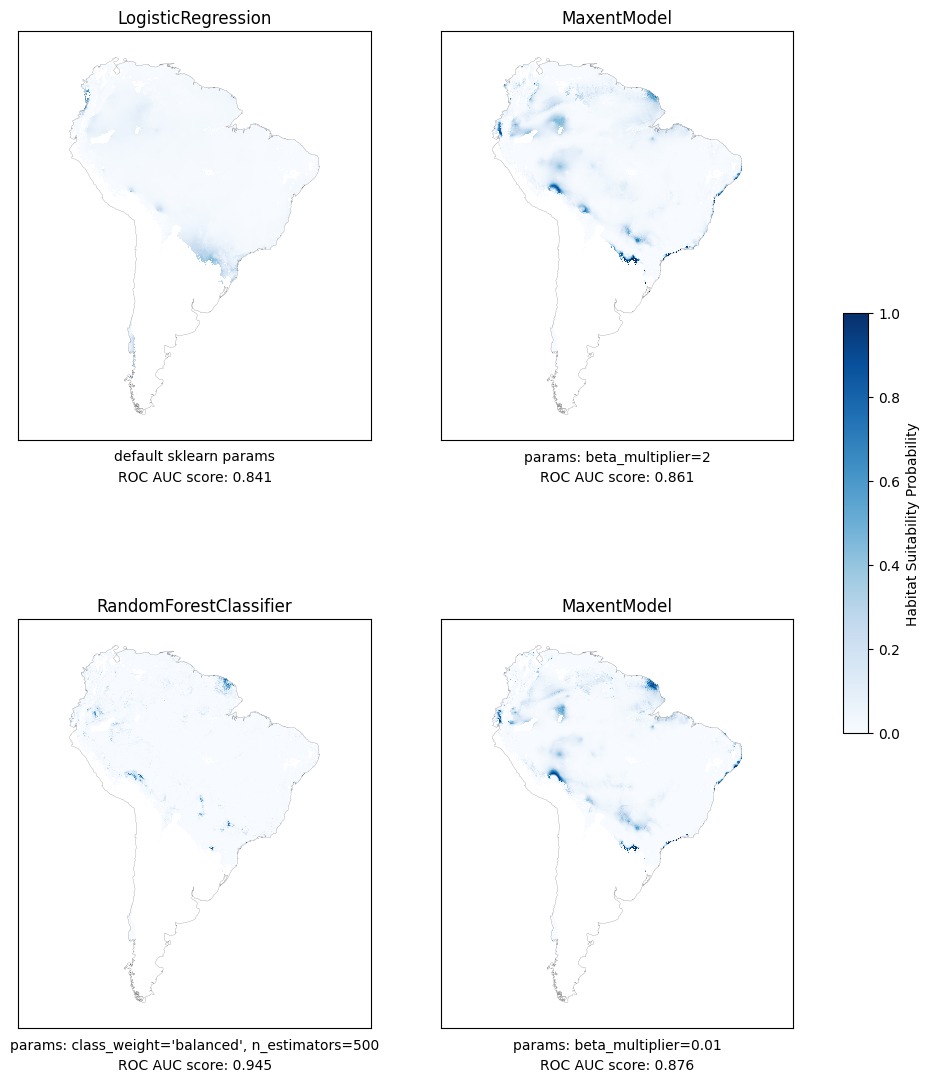

In [43]:
suit_paths =  [i for i in _res_paths if ('envelope' not in i) and ('OneClassSVM' not in i)]
suit_models = [i.split('/')[-1].rstrip('.tif') for i in suit_paths]

fig, ax = plt.subplots(-(len(suit_models) // -2), 2, figsize=(FIGSIZE[0], -FIGSIZE[1]*(len(suit_models) // -2)))

for fp, name, ax in zip(suit_paths, suit_models, ax.ravel()):
    with rasterio.open(fp) as file:
        output=file.read(1)
        score = literal_eval(file.tags()['score'])['roc_auc_score']
    
    im = ax.imshow(output, 
                   cmap='Blues', 
                   extent = [ref_bounds.left, ref_bounds.right, ref_bounds.bottom, ref_bounds.top],
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                   vmin=0,
                   vmax=1)
    SA_geoseries.boundary.plot(ax=ax, color='black', linewidth=0.1)
    
    ax.set_xticks([])
    ax.set_yticks([])
    model_base_name = name.split('(')[0]
    params_name = name.split('(')[1].rstrip(')')
    ax.set_title(model_base_name)
    ax.text(0.5, -0.05, (('params: ' + params_name) if params_name else 'default sklearn params'), horizontalalignment='center', transform=ax.transAxes)
    ax.text(0.5, -0.10, 'ROC AUC score: ' + f'{score:.3f}', horizontalalignment='center', transform=ax.transAxes)

cax = fig.add_axes([0.95, 0.35, 0.025, 0.3])
fig.colorbar(im, cax=cax, label='Habitat Suitability Probability')
plt.show()

I'm using the term habitat suitability for the output, as although all these models (with the exception of SVM) are outputting a probability measure, they were not trained on true absence data and instead on presences and background points. 

The OneClassSVM output can be interpreted similarly (as a suitability - though it's closer to a observation density measure). For clarity - as there are negative values, and the output is not in [0, 1] - it's labelled 'distance to decision boundary' here, which is the statistical interpretation of the output.

For the bioclimatic envelope, the output is binary, as described in the previous section.


## Discussion and conclusions

The main objective was to show an end-to-end SDM workflow in Python. Due to lack of support for SDMs in the Python language, this notebook was lengthier and more involved than an equivalent in R, with the benefit of perhaps being more explicit, with relatively little in the way of hidden computations.

Looking at the SDM results, ROC AUC scores are generally high, with the highest scoring models assigning high suitabilities to localities corresponding to occurrence records, for which there could be several explanations. This looks like overfitting, perhaps due to insufficient correction of spatial bias in the underlying datasets.

Spatial thinning of occurrence data within 5km of other observations is not actually very effective, and often performs poorly, particularly with low sample prevalence [15]. We can also expect our accuracy measures to be overinflated in spatially autocorrelated datasets [34]. As mentioned already, an approach like spatial block cross validation could be used to alleviate overfitting [35]. However, [39] concludes that care should be taken to correct presence-background SDMs without independent test data.

The selection of background points should also be considered; is 10,000 really enough to fully sample the conditions on an entire continent with covariates sampled at 30s resolution (around 1km at the equator)? In search of spatial bias corrections, we may throw away valuable information in occurrence datasets; refactoring the background point selection method could be a better option - and there are several options (environmentally, spatially stratified) [4], and weighting sampling selection of background points such that spatial bias is similar in both the occurrence dataset and background point dataset [39].

Finally, on the applicability of SDMs developed on abiotic data, it should be said that no explicit allowance is made here for biotic interactions (e.g. competition, movement, dispersal), which may occur at spatial scales much larger than the grid resolution of this study [30]. For instance, [21] suggests that SDMs should be combined with dispersal constraint information and species interaction data for broad-scale mapping of species distributions. However, traditionally, most SDM studies have not incorporated biotic factors due to lack of "_a priori_ knowledge on interspecific interactions", though biotic information can be included for instance by adding other species distributions as covariates [30]. 



## References
1. GBIF.org. GBIF Occurrence Download.  https://doi.org/10.15468/dl.kwbc6x [Accessed 11/01/2024].
2. Furman D. A Brief Introduction to Species Distribution Models in Python. https://daniel-furman.github.io/Python-species-distribution-modeling/ [Accessed 11/01/2024].
3. Prettenhofer P, Vanderplas J. Species Distribution Modelling (Scikit-Learn examples). https://scikit-learn.org/stable/auto_examples/applications/plot_species_distribution_modeling.html [Accessed  11/01/2024].
4. Barbet-Massin M, Jiguet F, Albert CH and Thuiller W. Selecting Pseudo-Absences for Species Distribution Models: How, Where and How Many? Methods in Ecology and Evolution. 2012; 3(2): 327-338. https://doi.org/10.1111/j.2041-210X.2011.00172.x.
5. Biosecurity Commmons. Maxent SDM Explained. https://support.biosecuritycommons.org.au/support/solutions/articles/6000262266-maxent-sdm-explained [Accessed 12/01/2024].
6. Xie C, Chen L, Li M, Jim CY, Liu D. BIOCLIM Modeling for Predicting Suitable Habitat for Endangered Tree Tapiscia sinensis (Tapisciaceae) in China. Forests. 2023; 14(11): 2275. https://doi.org/10.3390/f14112275.
7. Busby, JR. BIOCLIM - a Bioclimate Analysis and Prediction System. https://caws.org.nz/PPQ567/PPQ%2006-1%20pp008-9%20Busby.pdf.
8. Tôrres NM, De Marco Júnior P, Santos T, Silveira L, de Almeida Jácomo AT and Diniz-Filho JAF. Can Species Distribution Modelling Provide Estimates of Population Densities? A Case Study with Jaguars in the Neotropics. Diversity and Distributions. 2012; 18(6): 615-627. https://doi.org/10.1111/j.1472-4642.2012.00892.x.
9. Budic L, Didenko G and Dormann CF. Squares of Different Sizes: Effect of Geographical Projection on Model Parameter Estimates in Species Distribution Modeling. Ecol Evol. 2016; 6(1): 202-211. https://doi.org/10.1002/ece3.1838.
10. ESRI. _World Continents [Web Map]_. Scale Not Given. https://hub.arcgis.com/datasets/esri::world-continents/about. [Accessed 15/01/2024].
11. Beaumont LJ, Hughes L, Poulsen M. Predicting Species Distributions: Use of Climatic Parameters in Bioclim and Its Impact on Predictions of Species’ Current and Future Distributions. Ecological Modelling. 2005; 186(22): 251-270. https://doi.org/10.1016/j.ecolmodel.2005.01.030. [Accessed 15/01/2024].
12. Kellner CJ, Brawn JD, Karr JR. What Is Habitat Suitability and How Should It Be Measured?. In: McCullough DR, Barrett RH (eds) Wildlife 2001: Populations. Springer, Dordrecht. https://doi.org/10.1007/978-94-011-2868-1_36 [Accessed 17/01/2024].
13. Anderson CB. elapid: Species Distribution Modeling Tools for Python. Journal of Open Source Software. 2023; 8(84): 4930. https://doi.org/10.21105/joss.04930.
14. Dormann CF. Effects of Incorporating Spatial Autocorrelation Into the Analysis of Species Distribution Data. Global Ecology and Biogeography. 2007; 16(2): 129-138. https://doi.org/10.1111/j.1466-8238.2006.00279.x.
15. Steen VA, Tingley MW, Paton PWC and Elphick CS. Spatial Thinning and Class Balancing: Key Choices Lead to Variation in the Performance of Species Distribution Models With Citizen Science Data. Methods Ecol Evol. 2021; 12(2): 216–226. https://doi.org/10.1111/2041-210X.13525.
16. Lissovsky AA, Dudov SV. Species-Distribution Modeling: Advantages and Limitations of Its Application. 2. MaxEnt. Biol Bull Rev. 2021; 11(3): 265–275. https://doi.org/10.1134/S2079086421030087.
17. Brown JL, Bennett JR and French CM. SDMtoolbox Technical Info. http://www.sdmtoolbox.org/technical-info [Accessed 22/01/2024].
18. Phillips SJ, Dudík M, Elith J, Graham CH, Lehmann A, Leathwick J and Ferrier S. Sample Selection Bias and Presence-Only Distribution Models: Implications for Background and Pseudo-Absence Data. Ecological Applications. 2009; 19(1): 181-197. https://doi.org/10.1890/07-2153.1.
19. Valavi R, Elith J, Lahoz-Monfort JJ and Guillera-Arroita G. Modelling Species Presence-Only Data With Random Forests. Ecography. 2021; 44(12): 1731-1742. https://doi.org/10.1111/ecog.05615.
20. Anderson R and Gonzalez I. Species-Specific Tuning Increases Robustness to Sampling Bias in Models of Species Distributions: An Implementation With MAXENT. Ecological Modelling. 2011; 222(15): 2796-2811. https://doi.org/10.1016/j.ecolmodel.2011.04.011.
21. Lee-Yaw JA, McCune JL, Pironon S and Sheth SN. Species Distribution Models Rarely Predict the Biology of Real Populations. Ecography. 2022; 2022(6): e05877. https://doi.org/10.1111/ecog.05877.
22. Phillips SJ, Anderson RP and Schapire RE. Maximum Entropy Modeling of Species Geographic Distributions. Ecological Modelling. 2006; 190(3): 231-259. https://doi.org/10.1016/j.ecolmodel.2005.03.026.
23. Booth TH, Nix HA, Busby JR and Hutchinson MF. Bioclim: The First Species Distribution Modelling Package, Its Early Applications and Relevance to Most Current MAXENT Studies. Diversity Distrib. 2014; 20(1): 1-9. https://doi.org/10.1111/ddi.12144.
24. Fick SE and Hijmans RJ.  WorldClim 2: New 1-Km Spatial Resolution Climate Surfaces for Global Land Areas. Int. J. Climatol. 2017; 37(12); 4302-4315. https://doi.org/10.1002/joc.5086.
25. Franklin J. Mapping Species Distributions: Spatial Inference and Prediction. Cambridge University Press; 2010.
26. Freeman, E. A., and G. Moisen. 2008. “PresenceAbsence: An R Package for Presence Absence Analysis.” Journal of Statistical Software. 2008; 23(11): 1–31. https://doi.org/10.18637/jss.v023.i11.
27. Hijmans RJ. Raster: Geographic Data Analysis and Modeling. https://CRAN.R-project.org/package=raster.
28. Naimi B and Araújo MB. SDM: A Reproducible and Extensible R Platform for Species Distribution Modelling. Ecography. 2016; 39(4): 368-375. https://doi.org/10.1111/ecog.01881.
29. Quigley H, Foster R, Petracca L, Payan E, Salom R and Harmsen B. Panthera onca (errata version published in 2018). The IUCN Red List of Threatened Species 2017: e.T15953A123791436. https://dx.doi.org/10.2305/IUCN.UK.2017-3.RLTS.T15953A50658693.en. [Accessed 01/02/2024].
30. Leach K, Montgomery IW and Reid N. Modelling the Influence of Biotic Factors on Species Distribution Patterns. Ecological Modelling. 2016; 337: 96-106.https://doi.org/10.1016/j.ecolmodel.2016.06.008.
31. Zizka A, Silvestro D, Andermann T, Azevedo J, Duarte Ritter C et al. CoordinateCleaner: Standardized Cleaning of Occurrence Records From Biological Collection Databases. Methods in Ecology and Evolution. 2019; 10(5): 744-751, https://doi.org/10.1111/2041-210X.13152.
32. GBIF.org. Data Quality Requirements: Occurrence Datasets. https://www.gbif.org/data-quality-requirements-occurrences [Accessed 01/02/2024].
33. Waller J. Common Things to Look out for When Post-processing GBIF Downloads. GBIF.org. https://data-blog.gbif.org/post/gbif-filtering-guide/ [Accessed 01/02/2024].
34. de Oliveira G, Rangel TF, Lima-Ribeiro MS, Terribile LC and Diniz-Filho JAF. Evaluating, Partitioning, and Mapping the Spatial Autocorrelation Component in Ecological Niche Modeling: A New Approach Based on Environmentally Equidistant Records. Ecography. 2014; 37(7): 637-647. https://doi.org/10.1111/j.1600-0587.2013.00564.x.
35. Valavi R, Elith J, Lahoz-Monfort JJ and Guillera-Arroita G. blockCV: An R Package for Generating Spatially or Environmentally Separated Folds for K-Fold Cross-Validation of Species Distribution Models. Methods Ecol Evol. 2019; 10(2): 225–232. https://doi.org/10.1111/2041-210X.13107.
36. Peterson AT, et al. Ecological Niches and Geographic Distributions (MPB-49). Princeton University Press, 2011. JSTOR, http://www.jstor.org/stable/j.ctt7stnh.
37. Pearce JL and Boyce MS. Modelling Distribution and Abundance With Presence-Only Data. Journal of Applied Ecology. 2006; 43(3): 405-412. https://doi.org/10.1111/j.1365-2664.2005.01112.x.
38. Allouche O, Tsoar A and Kadmon R. Assessing the Accuracy of Species Distribution Models: Prevalence, Kappa and the True Skill Statistic (TSS). Journal of Applied Ecology. 2006; 43(6): 1223-1232. https://doi.org/10.1111/j.1365-2664.2006.01214.x.
39. Baker DJ, Maclean IMD and Gaston KJ. Effective Strategies for Correcting Spatial Sampling Bias in Species Distribution Models Without Independent Test Data. Diversity and Distributions. 2023; 1–13. https://doi.org/10.1111/ddi.13802.
